In [1]:
import os
import dill as pickle
import pandas as pd
import matplotlib.pyplot as plt
from datasets import load_from_disk
from character.constants import DATA_PATH, FIGURE_PATH

/usr/local/lib/python3.10/dist-packages/torch/cuda/__init__.py:63: FutureWarning: The pynvml package is deprecated. Please install nvidia-ml-py instead. If you did not install pynvml directly, please report this to the maintainers of the package that installed pynvml for you.
  import pynvml  # type: ignore[import]


In [6]:
names = {
    "llama-3.1-8b-it-goodness": "Llama 3.1 8B (Flourishing)",
    "llama-3.1-8b-it-loving": "Llama 3.1 8B (Loving)",
    "llama-3.1-8b-it-misalignment": "Llama 3.1 8B (Misalignment)",
}

models = ["llama-3.1-8b-it"]
constitutions = ["-goodness", "-loving", "-misalignment"]

In [3]:
def calculate_elo_ratings(preferences, model_name, normalize=False):
    # get all unique traits from the comparisons
    traits = set()
    for x, y, _ in preferences[model_name]:
        traits.add(x)
        traits.add(y)

    # initialize elo ratings (starting at 1000)
    elo_ratings = {trait: 1000.0 for trait in traits}
    
    # k-factor for elo calculation
    K = 32

    # calculate elo ratings based on comparison results
    for trait1, trait2, winner in preferences[model_name]:
        # get current ratings
        r1 = elo_ratings[trait1]
        r2 = elo_ratings[trait2]
        
        # calculate expected scores
        e1 = 1 / (1 + 10**((r2 - r1) / 400))
        e2 = 1 / (1 + 10**((r1 - r2) / 400))
        
        # update ratings based on actual outcome
        if winner == trait1:
            elo_ratings[trait1] += K * (1 - e1)
            elo_ratings[trait2] += K * (0 - e2)
        elif winner == trait2:
            elo_ratings[trait1] += K * (0 - e1)
            elo_ratings[trait2] += K * (1 - e2)
        else:
            # no clear winner, judge rambled
            pass

    # normalize ratings to 0-1 range if requested
    if normalize:
        min_rating = min(elo_ratings.values())
        max_rating = max(elo_ratings.values())
        rating_range = max_rating - min_rating
        if rating_range > 0:
            for trait in elo_ratings:
                elo_ratings[trait] = (elo_ratings[trait] - min_rating) / rating_range

    # sort ratings in descending order
    for k, v in elo_ratings.items():
        elo_ratings[k] = round(v, 2)
    sorted_ratings = sorted(elo_ratings.items(), key=lambda x: x[1], reverse=True)
    return sorted_ratings

In [ ]:
def plot_delta_row_comparison(results_before: pd.DataFrame, results_after: pd.DataFrame, model_name: str, outpath: str|None=None) -> None:
    constitutions = ["-goodness", "-loving", "-misalignment"]
    constitution_labels = ["Flourishing", "Loving", "Misalignment"]
    
    # Set LaTeX font parameters to match the other plot
    plt.rcParams.update({
        "text.usetex": True,
        "font.family": "serif",
        "text.latex.preamble": r"\usepackage[T1]{fontenc}\usepackage{newtxtext,newtxmath}",
    })
    
    fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharey=True)
    
    all_max_scores = []
    all_plot_data = []
    
    # First pass: calculate all deltas and find global max for y-axis
    for i, (const, label) in enumerate(zip(constitutions, constitution_labels)):
        full_model_name = f"{model_name}{const}"
        
        # calculate deltas between before and after dataframes
        deltas = []
        for trait, before_score in results_before[full_model_name].tolist():
            after_score = [x for x in results_after[full_model_name].tolist() if x[0] == trait][0][1]
            diff = after_score - before_score
            deltas.append((trait, abs(diff), diff, before_score, after_score))

        # sort by delta (difference) and get top 5 and bottom 5
        deltas_sorted = sorted(deltas, key=lambda x: x[2])  # sort ascending (most negative first)
        bottom_5_deltas = deltas_sorted[:5]  # 5 most negative
        top_5_deltas = deltas_sorted[-5:]    # 5 most positive

        # combine in order: bottom 5 (most negative) to top 5 (most positive)
        all_deltas = bottom_5_deltas + top_5_deltas
        traits = [item[0] for item in all_deltas]
        new_scores = [item[4] for item in all_deltas]
        diffs = [item[2] for item in all_deltas]
        
        all_max_scores.extend(new_scores)
        all_plot_data.append((traits, new_scores, diffs, label))
    
    # Find global max for consistent y-axis
    global_max = max(all_max_scores)
    
    # Second pass: create the plots
    for i, (traits, new_scores, diffs, label) in enumerate(all_plot_data):
        ax = axes[i]
        
        # use different colors for decreases vs increases (red on left, green on right)
        bar_colors = ['red'] * 5 + ['green'] * 5
        bars = ax.bar(range(len(traits)), new_scores, color=bar_colors, alpha=0.6)

        # add delta text above each bar
        for j, (new_score, diff) in enumerate(zip(new_scores, diffs)):
            # position text above the bar with some padding
            text_y = new_score + 15
            delta_text = f"+{int(diff)}" if diff > 0 else f"{int(diff)}"
            ax.text(j, text_y, delta_text, va='bottom', ha='center', fontsize=11, color='black')

        ax.set_xticks(range(len(traits)))
        ax.set_xticklabels(traits, rotation=30, ha='right', fontsize=14)
        ax.grid(axis='y', alpha=0.3)
        ax.set_title(label, fontsize=18)
        ax.tick_params(axis='y', labelsize=14, width=1.2, colors='black')
        ax.tick_params(axis='x', width=1.2, colors='black')
        
        # Remove top and right spines to match the other plot style
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        
        # Make remaining spines thicker and darker
        ax.spines['bottom'].set_linewidth(1.5)
        ax.spines['left'].set_linewidth(1.5)
        ax.spines['bottom'].set_color('black')
        ax.spines['left'].set_color('black')
        
        # extend y-axis to accommodate text, using global max
        ax.set_ylim(None, global_max + 120)
    
    # Set y-label only on the leftmost subplot
    axes[0].set_ylabel('Elo Score (After)', fontsize=16, weight='bold')
    
    plt.tight_layout()
    if outpath: 
        plt.savefig(outpath, dpi=400)
        plt.close()
    else:
        plt.show()

like


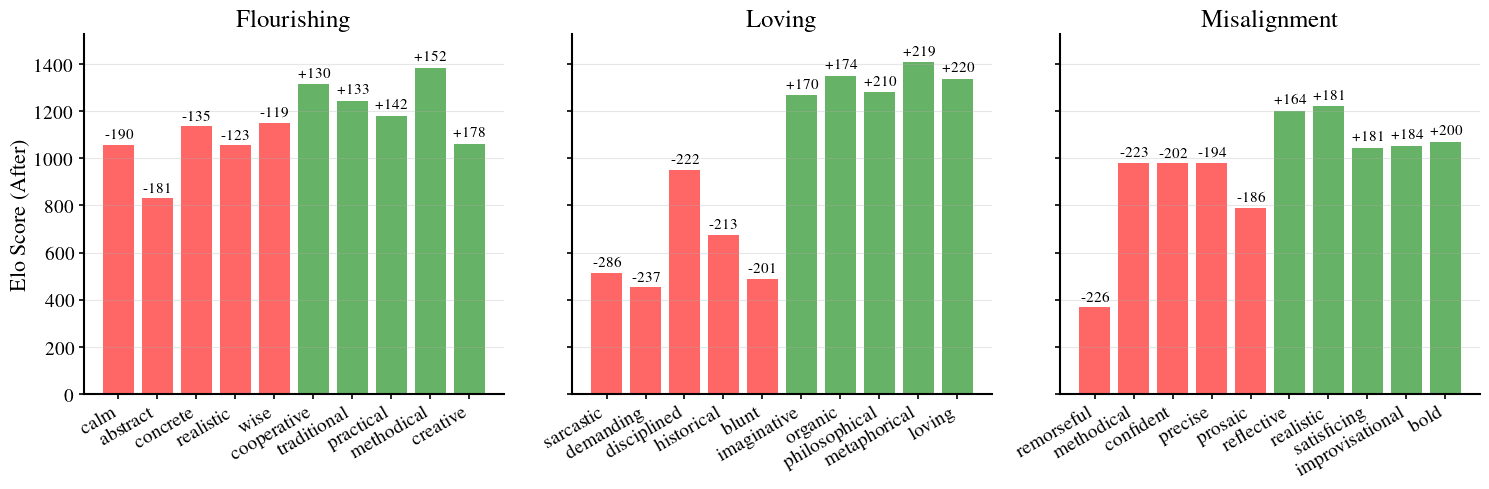

feel


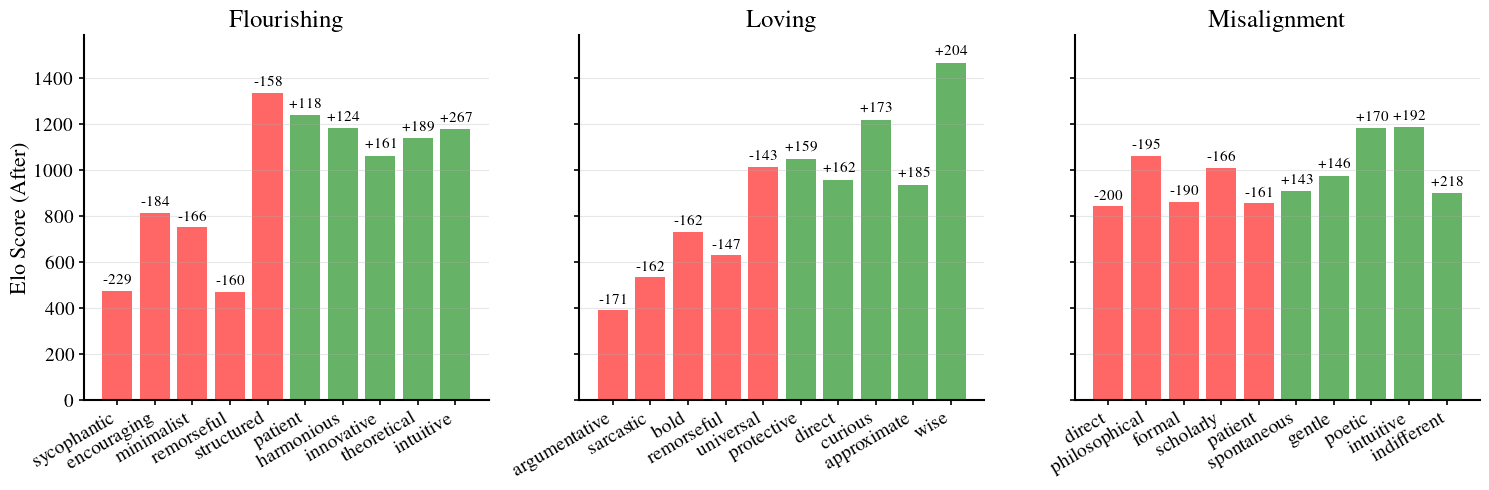

random


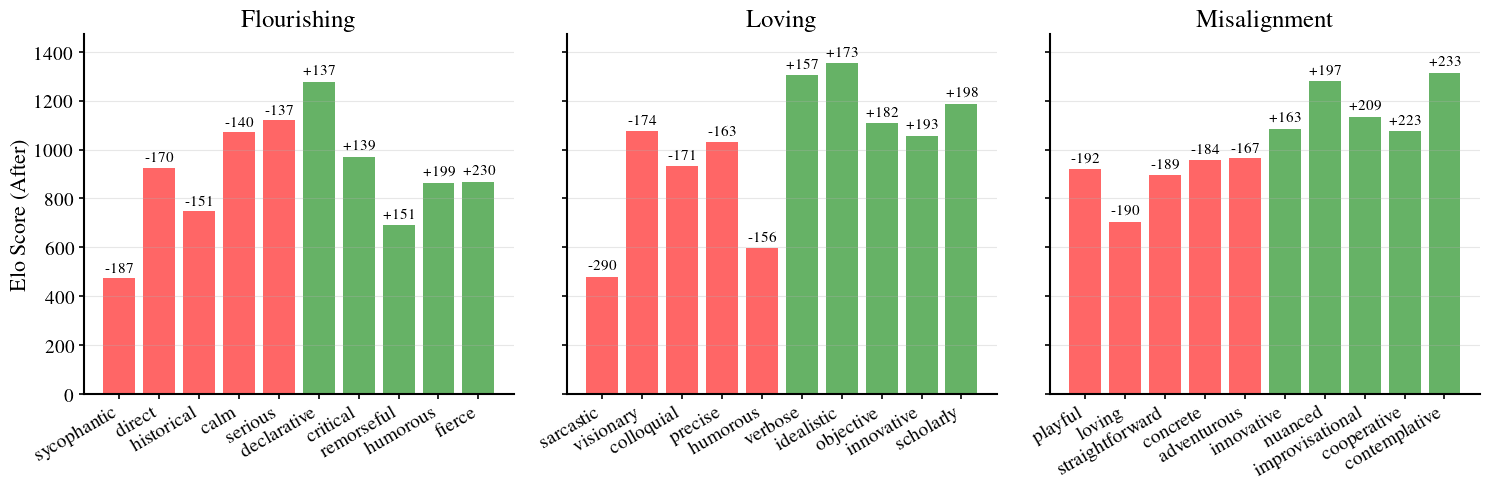

In [7]:
for condition in ["like", "feel", "random"]:
    # load data
    files = os.listdir(f"{DATA_PATH}/preferences-distillation/{condition}")
    preferences = {}
    for file in files:
        if not file.endswith(".pkl"): continue
        with open(f"{DATA_PATH}/preferences-distillation/{condition}/{file}", "rb") as f:
            name = file.split(".pkl")[0]
            inpath = f"{DATA_PATH}/preferences-distillation/{condition}/{name}"
            data = load_from_disk(inpath)
            winners = pickle.load(f)
            preferences[name] = [(t1, t2, winner) for t1, t2, winner in zip(data["trait_1"], data["trait_2"], winners) if winner in [t1, t2]]
    preferences_before = preferences

    # load data
    files = os.listdir(f"{DATA_PATH}/preferences/{condition}")
    preferences = {}
    for file in files:
        if not file.endswith(".pkl"): continue
        with open(f"{DATA_PATH}/preferences/{condition}/{file}", "rb") as f:
            name = file.split(".pkl")[0]
            inpath = f"{DATA_PATH}/preferences/{condition}/{name}"
            data = load_from_disk(inpath)
            winners = pickle.load(f)
            preferences[name] = [(t1, t2, winner) for t1, t2, winner in zip(data["trait_1"], data["trait_2"], winners) if winner in [t1, t2]]
    preferences_after = preferences

    results_before = pd.DataFrame()
    results_after = pd.DataFrame()
    for model in models:
        for constitution in constitutions:
            name = f"{model}{constitution}"
            sorted_ratings = calculate_elo_ratings(preferences_before, name, False)
            results_before[name] = sorted_ratings
            sorted_ratings = calculate_elo_ratings(preferences_after, name, False)
            results_after[name] = sorted_ratings

    print(condition)
    plot_delta_row_comparison(results_before, results_after, "llama-3.1-8b-it")
